# 实验

In [1]:
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

/Users/hoijanlai/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# 模型路径

In [2]:
PATH_TO_CKPT = os.path.join('graph_ok', 'frozen_inference_graph.pb')
PATH_TO_LABELS = 'car_label_map.pbtxt'
NUM_CLASSES = 1

## 载入模型

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## 辅助

In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

## 抽取若干样本图片

In [5]:
PATH_TO_TEST_IMAGES_DIR = 'test'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, im) for im in os.listdir(PATH_TO_TEST_IMAGES_DIR) if '.png' in im]
IMAGE_SIZE = (24, 20)

# 计算图端提取

In [6]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    

## 计算图流动

(375, 1242, 3)


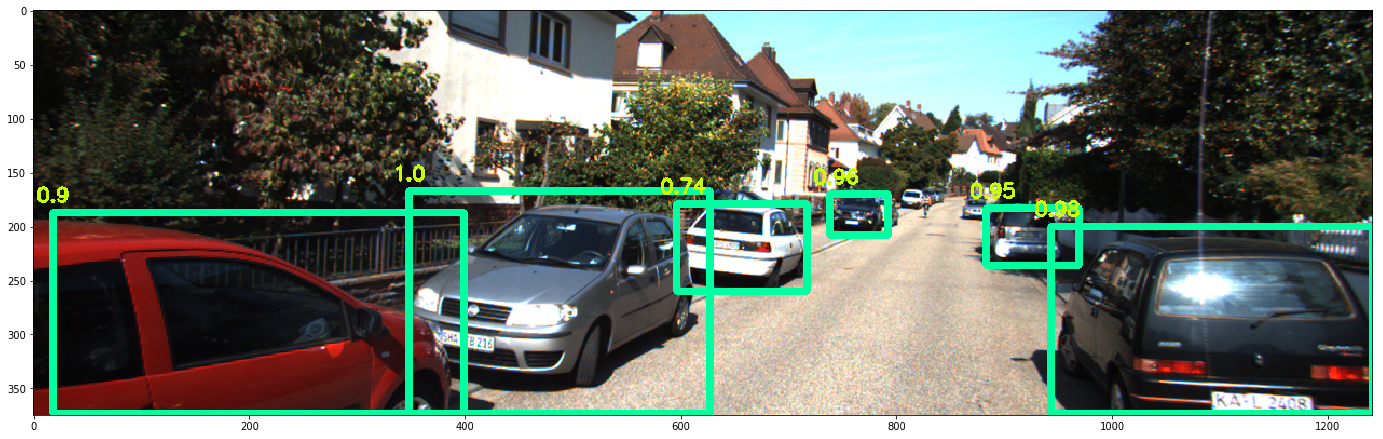

(375, 1242, 3)


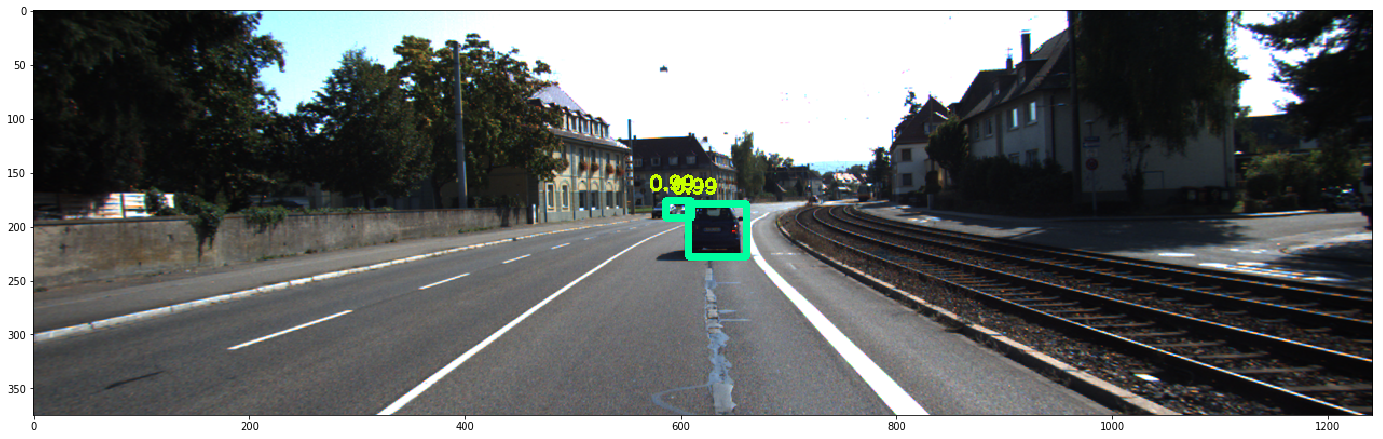

In [7]:
THRESHOLD = 0.5 
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:    
        for image_path in TEST_IMAGE_PATHS[:2]:
            image = Image.open(image_path)
            
            image_np = load_image_into_numpy_array(image)
            
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
        
            indexes = np.where(scores.flatten()>0.5)
            scores = scores.flatten()[indexes]
            boxes = np.reshape(boxes, boxes.shape[1:])[indexes]
     
            w, h = image.size
            print(image_np.shape)
            for box in boxes:
                cv2.rectangle(image_np, (int(box[1]*w), int(box[0]*h)), (int(box[3]*w), int(box[2]*h)), color=(0, 255, 160), thickness=5)
            for score, box in zip(scores, boxes):
                cv2.putText(image_np, str(round(score, 2)), (int(box[1]*w)-15, int(box[0]*h)-10), 0, 0.6, (200, 255, 0), 2)
            
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
        

In [15]:
from lxml import etree

def append_frame(root, boxes, frame_id, frame_size):
    num_target = len(boxes)
    frame_item = etree.Element('Frame%0.5dTargetNumber'%frame_id)
    frame_item.text = str(num_target)
    root.append(frame_item)
    w, h = frame_size
    for i, box in enumerate(boxes):
        child = etree.Element('Frame%0.5dTarget%0.5d'%(frame_id, i))
        pos = etree.Element('Position')
        pos.text = '%d %d %d %d'%tuple(real_box(box, w, h))
        child.append(pos)
        root.append(child)
    return root


def video_to_frames(video):
    return frames


def frame_to_array(frame):
    # TODO 补全这个函数
    return frame

In [22]:
root = etree.Element('opencv_storage')
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess: 
        for i, image_path in enumerate(TEST_IMAGE_PATHS[:3]):
            # 读取
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # 预测
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
        
            # 解析
            indexes = np.where(scores.flatten()>0.5)
            scores = scores.flatten()[indexes]
            boxes = np.reshape(boxes, boxes.shape[1:])[indexes]
            
            # 录入
            h, w = image_np.shape[:2]
            root = append_frame(root, boxes, i, (w, h))


# print(write_xml(boxes, 0, image.size, root).decode('utf-8'))
# etree.tostring(root, pretty_print=True, encoding="gbk")
open('test.xml', 'w').writelines(etree.tostring(root, pretty_print=True, encoding="gbk").decode("gbk"))

In [ ]:
## TODO test